## Загрузим данные с метками

In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
sns.set()
warnings.simplefilter("ignore")

In [2]:
def ohe_pandas_inplace(data, feature, remove_feature=False):
    for f in datap[feature].unique():
        data[feature + '=' + i] = (data['feature'] == i).astype(float)
    if remove_feature:
        data.drop(labels=[feature], axis=1, inplace=True)

In [3]:
data = pd.read_csv('./data.csv')

![](data_description.png)

https://www.kaggle.com/obrienmitch94/alzheimer-s-analysis

In [4]:
mask = data.CDR.notnull()

In [5]:
data = data[mask]

In [6]:
data.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay'],
      dtype='object')

In [7]:
data.nunique()

ID       235
M/F        2
Hand       1
Age       51
Educ       5
SES        5
MMSE      17
CDR        4
eTIV     191
nWBV     131
ASF      185
Delay      0
dtype: int64

In [8]:
data.head()

ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
8  OAS1_0010_MR1   M    R   74   5.0  2.0  30.0  0.0  1636  0.689  1.073   
9  OAS1_0011_MR1   F    R   52   3.0  2.0  30.0  0.0  1321  0.827  1.329   

   Delay  
0    NaN  
1    NaN  
2    NaN  
8    NaN  
9    NaN

In [9]:
data.drop(labels=['ID', 'Hand', 'Delay'], axis=1, inplace=True)

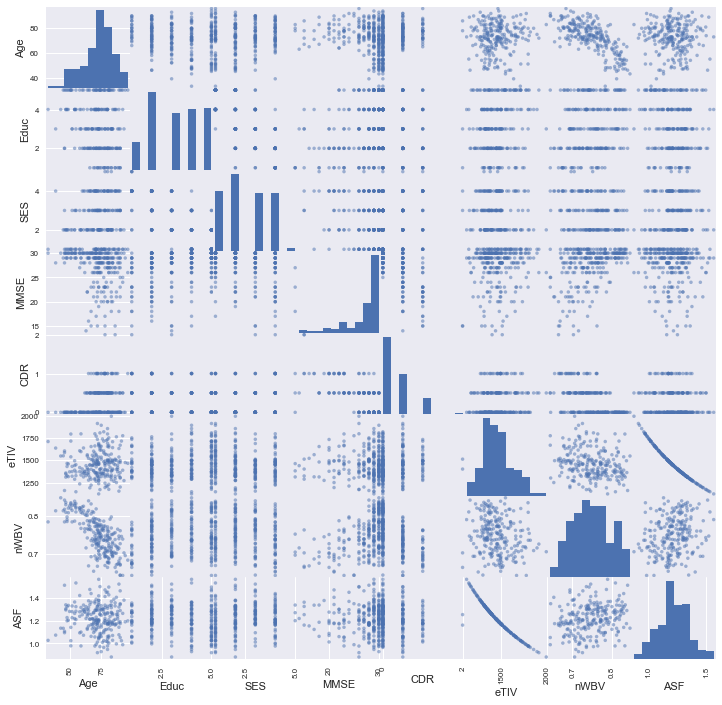

In [10]:
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

### Загрузим данные с изображением мозгов(опять, мозги)

Разложим на независимые компоненты датасет предсказания болезни Альцгеймера на ранней стадии (https://www.oasis-brains.org/): База данных состоит из 2D снимков (центральных, поперечного сечения) для 416 субъектов, возрастом от 18 до 96 лет. Данные были предобработаны и стандартизованы, мы развернули их в одномерный вектор и положили в csv файл, все для вас :)

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
def spectrum(x):
    f = np.fft.fft2(x)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift))
    return magnitude_spectrum

In [12]:
brain_data = pd.read_csv('./brain_data.csv.zip')[mask]
brain_data.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [13]:
X_brain = np.log(brain_data.values / 255. + 1)
X_brain_image = X_brain.reshape((-1, 176, 176))
age = data.Age.values
cdr = (data.CDR.values == 0).astype(int)

In [14]:
X_fft = []
for image in X_brain_image:
    X_fft.append(spectrum(image))
X_fft = np.array(X_fft)

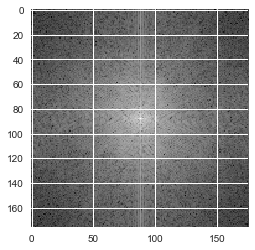

In [15]:
plt.imshow(X_fft[0], cmap='gray')

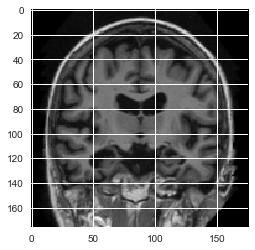

In [16]:
plt.imshow(X_brain_image[2], cmap='gray')
plt.show()

### Напишем свой собственный SVD и PCA

In [17]:
class MySVD:
    """
    Класс для итеративного нахождения SVD-разложения
    """
    def __init__(self, tol=1e-10, eigval_thr=1e-10, max_iter=100, random_state=0, verbose=False):
        """
        Аргументы:
        - tol: норма разности
        - eigval_thr: 
        """
        self.tol = tol
        self.eigval_thr = eigval_thr
        self.max_iter = max_iter
        self.gen = np.random.RandomState(random_state)
        self.verbose = verbose
        
    def _initialize(self, X, n_components):
        self.X = np.array(X)
        assert self.X.ndim == 2
        # Сингулярные значения
        self.eig_vals = []
        # Левые сингулярные векторы
        self.eig_vecs_left = []
        # Правые сигнулярные векторы
        self.eig_vecs_right = []
        n_components = self.X.shape[0] if n_components is None else n_components
        self.n_components = min(self.X.shape[0], self.X.shape[1], n_components)
        
    def _make_step(self, X, a, b):
        # <YOUR CODE>
        new_b = (b + X.T.dot(a) / np.sum(a**2)) / 2
        new_a = (a + X.dot(b) / np.sum(b**2)) / 2

        return new_a, new_b
        
    def __call__(self, X, n_components=None):
        self._initialize(X, n_components)
        # Запускаем итеративный процесс нахождения компонент
        for n_component in range(self.n_components):
            a = self.gen.rand(self.X.shape[0])
            b = self.gen.rand(self.X.shape[1])
            
            prev_F = np.sum((self.X - a[:, None] * b[None, :])**2)
            delta_F = np.inf
            
            # Итерируемся до тех пор, пока не достигнем максимального числа итераций
            # или не достигнем минимума с заданной точностью
            for n_iter in range(self.max_iter):
                a, b = self._make_step(self.X, a, b)
                F = np.sum((self.X - a[:, None] * b[None, :])**2)
                delta = prev_F - F
                prev_F = F
                self._print('n_eig = {}, n_iter = {}: delta = {:.5f}, F = {:.5f}.'.format(
                        len(self.eig_vals), n_iter, delta, F))
                if np.abs(delta) <= self.tol:
                    self._print('Frobenius norm equals {}. Stopping iterations for n_eig={}.'.format(
                        F, len(self.eig_vals)))
                    break
                    
            eig_val = np.sum(a**2) * np.sum(b**2) # Собственные значения матриц XX^T и X^TX
            # Критерий остановки
            if eig_val < self.eigval_thr:
                self._print('Singular value {} equals {}. Stopping iterations.'.format(
                    len(self.eig_vals) + 1, eig_val))
                break
            self.eig_vals.append(eig_val)
            self.eig_vecs_left.append(a[:, None] / np.sqrt(np.sum(a**2)))
            self.eig_vecs_right.append(b[:, None] / np.sqrt(np.sum(b**2)))
            self.X -= a[:, None] * b[None, :]

        self.U = np.hstack(self.eig_vecs_left)
        self.V = np.hstack(self.eig_vecs_right)
        self.D = np.sqrt(self.eig_vals)
        return self.U, self.D, self.V.T
    
    def _print(self, msg):
        if self.verbose:
            print(msg)

In [18]:
test_array = np.random.randn(10, 3)
u_np, d_np, v_np = np.linalg.svd(test_array, full_matrices=False)
u, d, v = MySVD(verbose=False)(test_array)

assert np.allclose(d, d_np, atol=1e-2)
assert np.allclose(np.dot(np.dot(u, np.diag(d)), v), test_array, atol=1e-2)

In [19]:
class MyPCA:
    def __init__(self, n_components=10, **svd_kwargs):
        self.n_components=n_components
        self.svd = MySVD(**svd_kwargs)
        
    def fit(self, X):
        X = np.array(X)
        self.n_samples, self.n_features = X.shape
        
        # Центрирование данных
        self.mean_ = X.mean(axis=0)
        X = X - self.mean_[None, :]

        
        # Полная дисперсия данных, т.е. 
        # сумма квадратов расстояний от центра
        self.full_variance_ = np.sum(np.mean(X**2, axis=0))
        
        # SVD-разложение
        self.U, self.D, self.V = self.svd(X, n_components=self.n_components)
        
        # Собственные векторы матрицы X^TX в V.T
        self.n_components_ = len(self.D)
        self.components_ = self.V
        
        # Доля обоснованной дисперсии
        self.explained_variance_ = self.D**2 / self.n_samples
        self.explained_variance_ratio_ = self.explained_variance_ / self.full_variance_

    def transform(self, X):
        return np.dot(X - self.mean_[None, :], self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def recover(self, X):
        return np.dot(X, self.components_) + self.mean_[None, :]

### Наглядное объяснение метода главных компонент

Объяснённая дисперсия: [0.94604005 0.05395995]
Направления главных компонент:
Первая: [-0.58358182  0.81205434]
Вторая: [-0.58358182  0.81205434]


(-4.324367936869107, 3.3984827354832388, -5.442479048097213, 6.051335425551118)

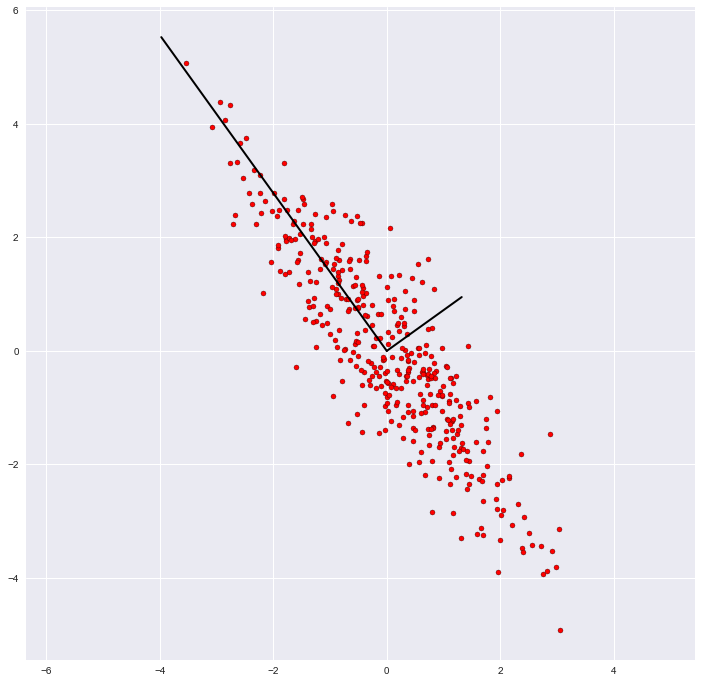

In [20]:
mean = np.array([0.0, 0.0])
cov  = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])

X = np.random.multivariate_normal(mean, cov, 400)

pca = MyPCA(n_components=2)
pca.fit(X)

print("Объяснённая дисперсия: {}".format(pca.explained_variance_ratio_))
print("Направления главных компонент:")
print("Первая: {}".format(pca.components_[0]))
print("Вторая: {}".format(pca.components_[0]))


plt.figure(figsize=(12, 12))

plt.scatter(X[:, 0], X[:, 1], s=25, c='r', marker='o', edgecolor='k')

for var_ratio, direction in zip(pca.explained_variance_ratio_, pca.components_):
    d = 7 * np.sqrt(var_ratio) * direction
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=2)

plt.axis('equal')

Объяснённая дисперсия: [0.94604005 0.05395995]
Направления главных компонент:
Первая: [-0.58358191  0.81205428]
Вторая: [-0.58358191  0.81205428]


(-4.324368580632056, 3.3984827661386174, -5.442479026066771, 6.051334962911813)

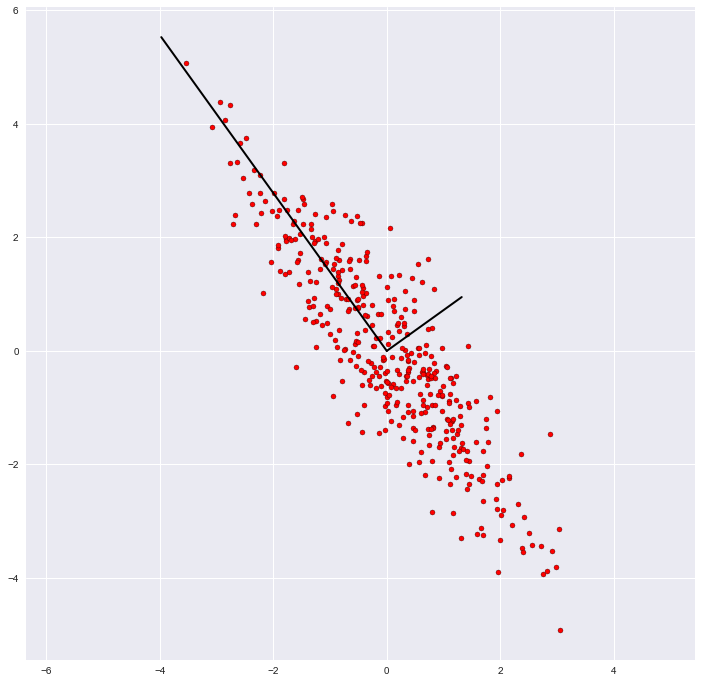

In [21]:
pca = PCA(n_components=2)
pca.fit(X)

print("Объяснённая дисперсия: {}".format(pca.explained_variance_ratio_))
print("Направления главных компонент:")
print("Первая: {}".format(pca.components_[0]))
print("Вторая: {}".format(pca.components_[0]))


plt.figure(figsize=(12, 12))

plt.scatter(X[:, 0], X[:, 1], s=25, c='r', marker='o', edgecolor='k')

for var_ratio, direction in zip(pca.explained_variance_ratio_, pca.components_):
    d = 7 * np.sqrt(var_ratio) * direction
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=2)

plt.axis('equal')

### Применим PCA к изображениям мозгов

In [22]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
def plot_embedding(X, y, images_small=None, title=None):
    """
    Функция для рисования эмбеддингов 
    с цветами соответствующими y
    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)
    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.3)
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')                                  
            ax.add_artist(ab)
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

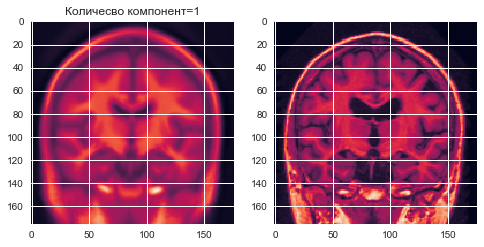

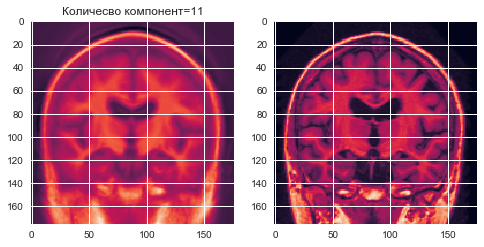

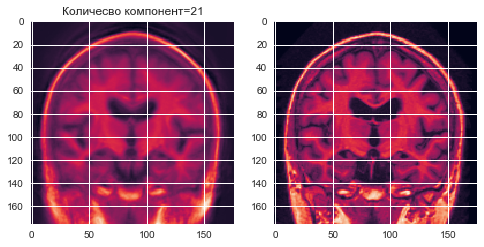

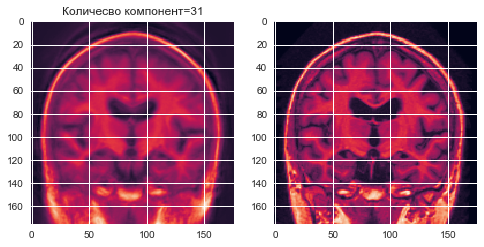

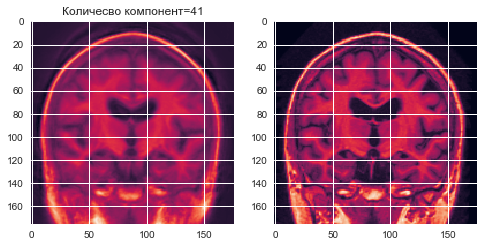

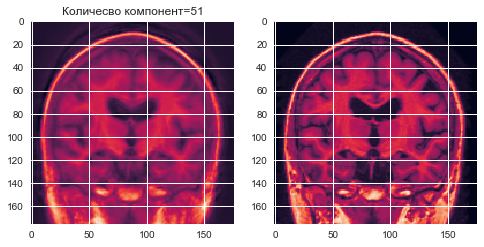

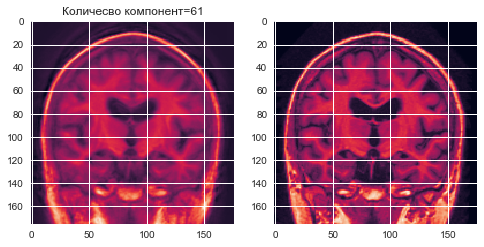

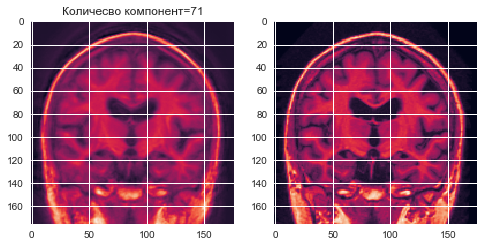

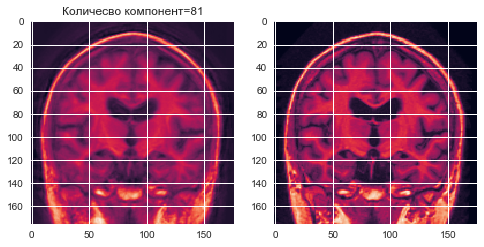

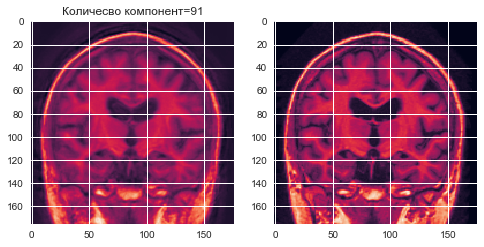

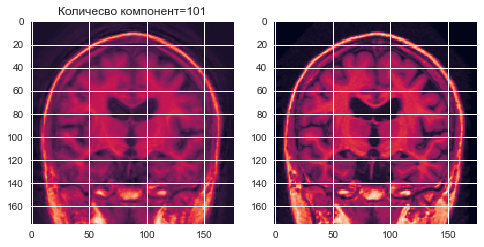

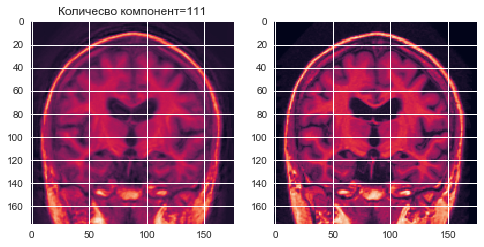

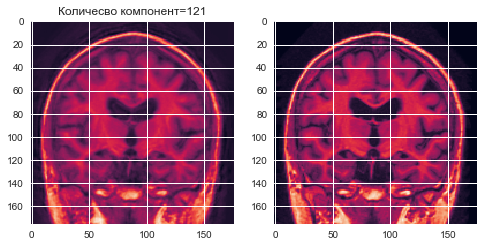

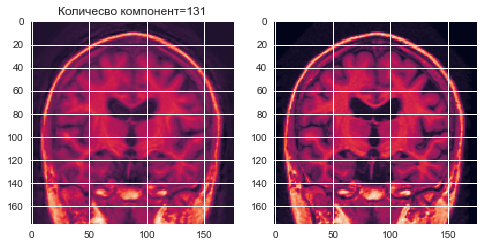

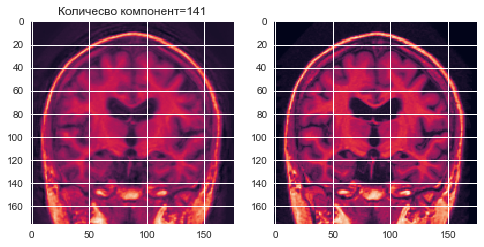

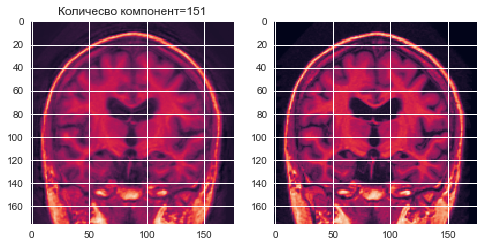

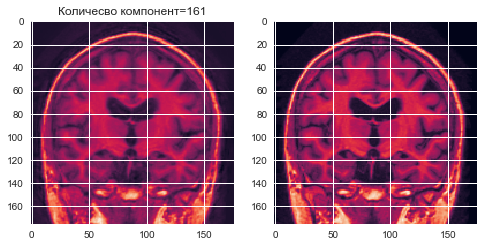

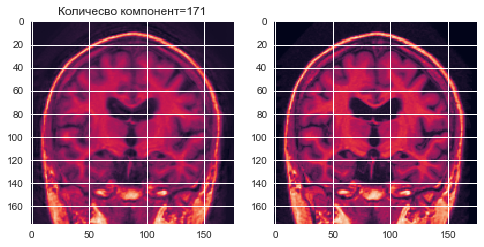

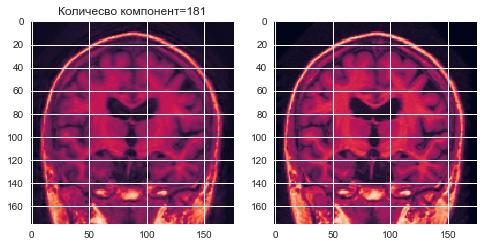

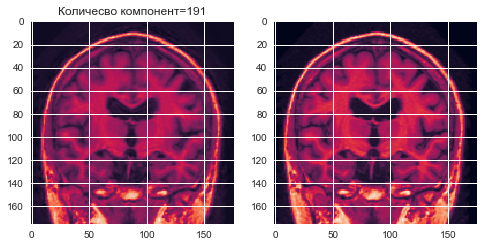

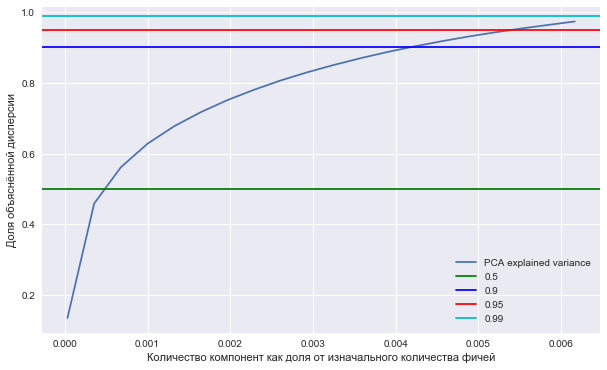

In [23]:
n_components = np.arange(1, 200, 10)
pca_error = []

for n in n_components:
    pca = PCA(n_components=n).fit(brain_data)
    # возвращает норму Фробениуса оригинала от реконструкции
    pca_error.append(pca.explained_variance_ratio_.sum())
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(pca.inverse_transform(pca.transform(brain_data))[0].reshape((176, 176)))
    ax[0].set_title("Количесво компонент={}".format(n))
    ax[1].imshow(X_brain_image[0])
    plt.show()
    
# Построим, что у нас получилось    
plt.figure(figsize=(10, 6))
plt.plot(n_components / brain_data.shape[1], pca_error, "-", label='PCA explained variance')
plt.axhline(y=0.5, linestyle='-', c='g', label='0.5')
plt.axhline(y=0.9, linestyle='-', c='b', label='0.9')
plt.axhline(y=0.95, linestyle='-', c='r', label='0.95')
plt.axhline(y=0.99, linestyle='-', c='c', label='0.99')
plt.xlabel('Количество компонент как доля от изначального количества фичей')
plt.ylabel('Доля объяснённой дисперсии')
plt.legend()

## Ядерные/нелинейные методы снижения размерности

План:
  * PCA + предсказание age/cdr

### PCA

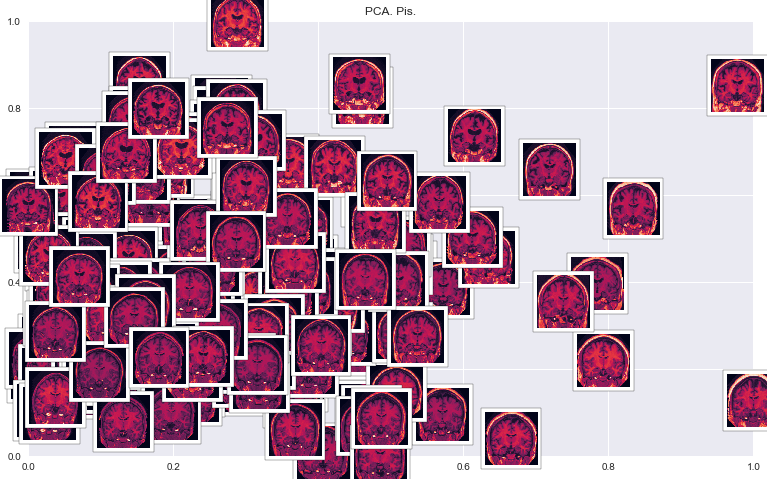

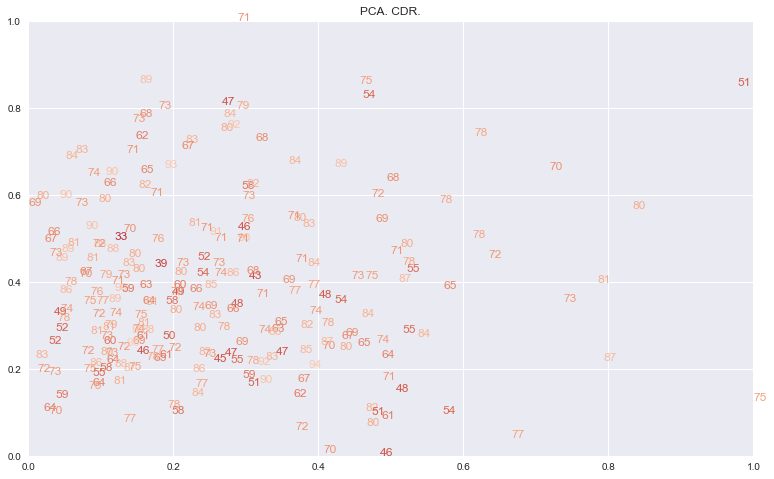

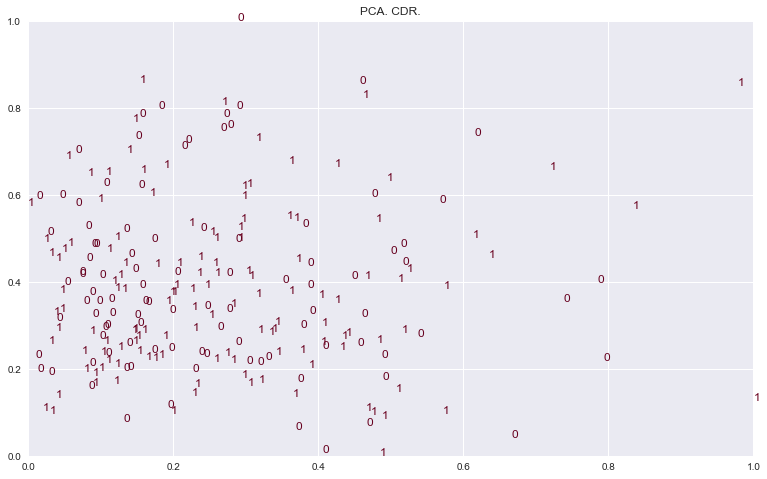

In [24]:
X_projected = PCA(n_components=100).fit_transform(brain_data)

plot_embedding(X_projected, cdr, X_brain_image, "PCA. Pis.")
plot_embedding(X_projected, age, title="PCA. CDR.")
plot_embedding(X_projected, cdr, title="PCA. CDR.")

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

scores = cross_val_score(estimator=XGBClassifier(learning_rate=1e-2, n_estimators=300), 
                         X=X_projected, 
                         y=LabelEncoder().fit_transform(cdr), 
                         cv=5,
                         scoring='roc_auc')

print('Средняя точность: {} +- {}'.format(np.mean(scores), np.std(scores)))

Средняя точность: 0.5151851851851852 +- 0.04795402462115415


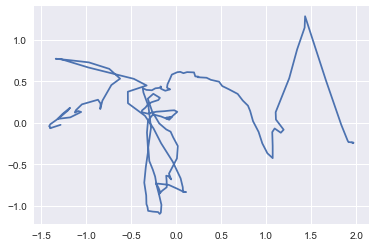

In [34]:
plt.plot(*PCA(n_components=2).fit_transform(X_brain_image[0]).T)

### Нейронка

In [26]:
from keras.layers import Input, Dense, Flatten, Dropout, merge, Reshape, Conv2D
from keras.layers import MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

def autoencoder(input_img):
    conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)
    
    conv2 = Conv2D(6, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(6, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(4, 4))(conv2)
    
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    
    encoded = Flatten()(conv3)

    #decoder
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((4, 4))(conv4)
    
    conv5 = Conv2D(6, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(6, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((4, 4))(conv5)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return encoded, decoded

Using TensorFlow backend.


In [29]:
input_img = Input(shape = (176, 176, 1))
encoded, decoded = autoencoder(input_img)

encoder = Model(input_img, encoded)
decoder = Model(input_img, decoded)

decoder.compile(optimizer=Adam(lr=1e-1), loss='binary_crossentropy')

X_image_tf = X_brain.reshape((-1, 176, 176, 1))

In [30]:
decoder.fit(X_image_tf, X_image_tf, batch_size=64,
            epochs=100, shuffle=True)

Epoch 1/100
235/235 [==============================] - 15s 65ms/step - loss: 0.8245
Epoch 2/100
235/235 [==============================] - 14s 58ms/step - loss: 0.5225
Epoch 3/100
235/235 [==============================] - 14s 60ms/step - loss: 0.4460
Epoch 4/100
235/235 [==============================] - 16s 69ms/step - loss: 0.4473
Epoch 5/100
235/235 [==============================] - 14s 59ms/step - loss: 0.4413
Epoch 6/100
235/235 [==============================] - 14s 57ms/step - loss: 0.4377
Epoch 7/100
235/235 [==============================] - 14s 57ms/step - loss: 0.4357
Epoch 8/100
235/235 [==============================] - 13s 57ms/step - loss: 0.4331
Epoch 9/100
235/235 [==============================] - 13s 57ms/step - loss: 0.4307
Epoch 10/100
235/235 [==============================] - 13s 57ms/step - loss: 0.4288
Epoch 11/100
235/235 [==============================] - 14s 58ms/step - loss: 0.4271
Epoch 12/100
235/235 [==============================] - 13s 57ms/step - lo

235/235 [==============================] - 13s 57ms/step - loss: 0.4050
Epoch 98/100
235/235 [==============================] - 13s 57ms/step - loss: 0.4048
Epoch 99/100
235/235 [==============================] - 13s 57ms/step - loss: 0.4047
Epoch 100/100
235/235 [==============================] - 14s 58ms/step - loss: 0.4046


In [31]:
X_projected_nn = encoder.predict(X_image_tf)

In [35]:
scores = cross_val_score(estimator=XGBClassifier(learning_rate=1e-2, n_estimators=300), 
                         X=X_projected_nn, 
                         y=LabelEncoder().fit_transform(cdr), 
                         cv=5,
                         scoring='roc_auc')

print('Средняя точность: {} +- {}'.format(np.mean(scores), np.std(scores)))

Средняя точность: 0.5266666666666666 +- 0.04500571522920373


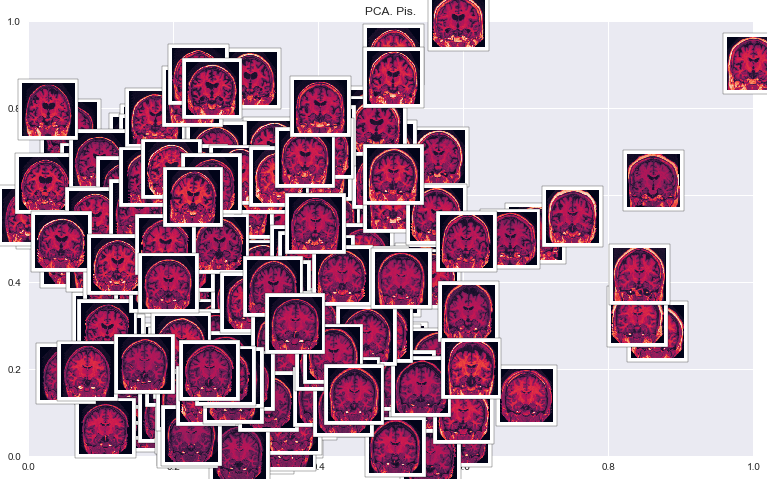

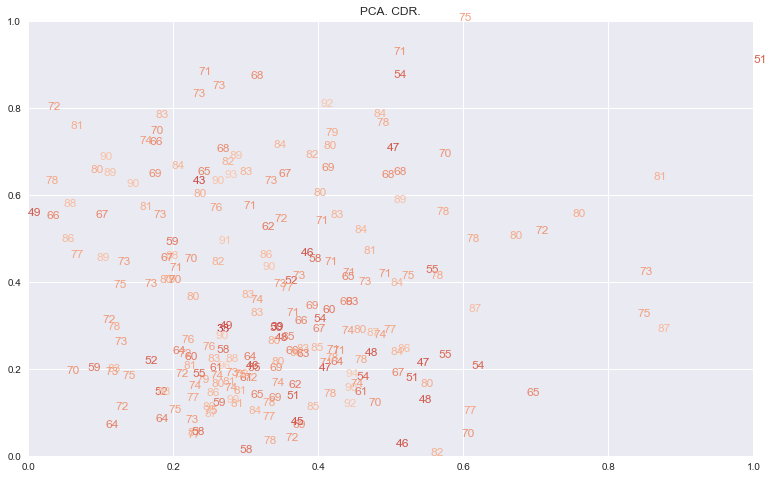

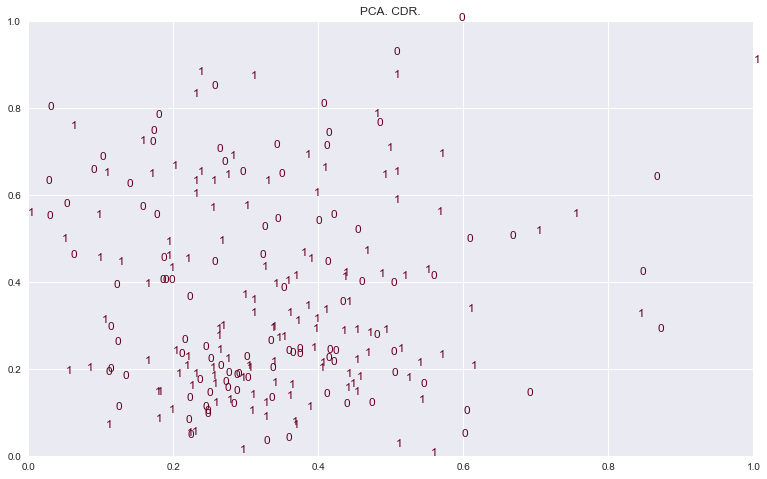

In [33]:
X_projected = PCA(n_components=100).fit_transform(X_projected_nn)

plot_embedding(X_projected, cdr, X_brain_image, "PCA. Pis.")
plot_embedding(X_projected, age, title="PCA. CDR.")
plot_embedding(X_projected, cdr, title="PCA. CDR.")